1. Overnight long trade in SPY (S&P 500)
Buy at CLOSE. 

[*********************100%***********************]  1 of 1 completed

Performance Metrics
Total Trades: 7765
Win Ratio: 53.34%
Average Gain per Trade: 0.0004
Average Gain (Winners): 0.0078
Average Loss (Losers): -0.0081
Profit Factor: 1.0985
Max Drawdown: -56.47%
CAGR: 7.87%


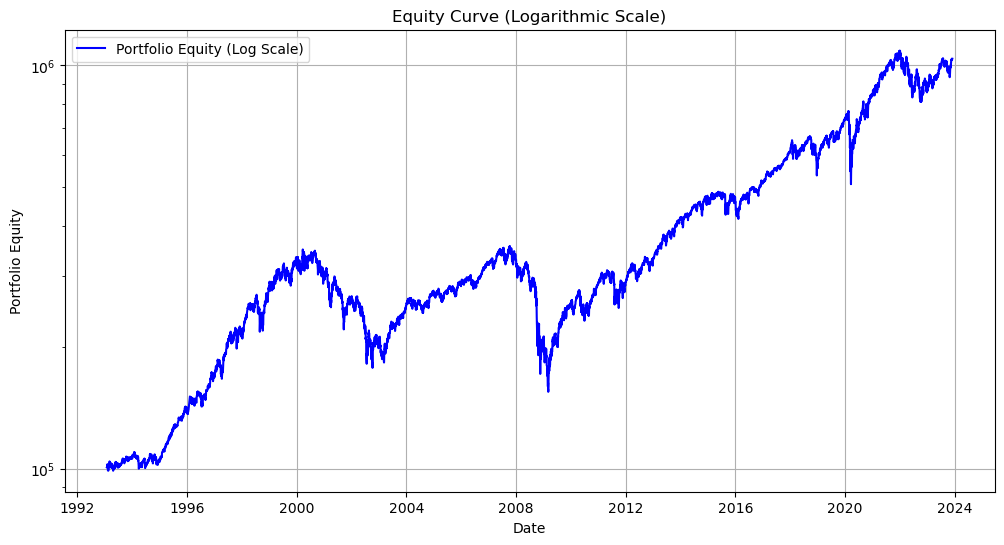

In [11]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download Historical SPY Data
def download_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data['Return'] = data['Close'].pct_change()
    return data

# Simulate the Overnight Strategy
def simulate_strategy(data, initial_capital):
    # Simulate overnight returns
    data['Overnight Return'] = (data['Close'].shift(-1) - data['Close']) / data['Close']
    
    # Calculate portfolio equity
    data['Portfolio Equity'] = initial_capital * (1 + data['Overnight Return'].fillna(0)).cumprod()
    return data

# Calculate Performance Metrics
def calculate_performance(data):
    total_trades = len(data['Overnight Return'].dropna())
    winning_trades = data[data['Overnight Return'] > 0]
    losing_trades = data[data['Overnight Return'] <= 0]
    win_ratio = len(winning_trades) / total_trades if total_trades > 0 else 0
    avg_gain = data['Overnight Return'].mean()
    avg_gain_winners = winning_trades['Overnight Return'].mean() if not winning_trades.empty else 0
    avg_loss_losers = losing_trades['Overnight Return'].mean() if not losing_trades.empty else 0
    profit_factor = (winning_trades['Overnight Return'].sum() /
                     abs(losing_trades['Overnight Return'].sum())) if not losing_trades.empty else float('inf')
    max_drawdown = (data['Portfolio Equity'] / data['Portfolio Equity'].cummax() - 1).min()
    cagr = ((data['Portfolio Equity'].iloc[-1] / data['Portfolio Equity'].iloc[0]) ** 
            (1 / (len(data) / 252)) - 1)  # Assumes 252 trading days per year

    return {
        'Total Trades': total_trades,
        'Win Ratio': win_ratio,
        'Average Gain per Trade': avg_gain,
        'Average Gain (Winners)': avg_gain_winners,
        'Average Loss (Losers)': avg_loss_losers,
        'Profit Factor': profit_factor,
        'Max Drawdown': max_drawdown,
        'CAGR': cagr
    }

# Plot Equity Curve (Log Scale)
def plot_equity_curve(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Portfolio Equity'], label='Portfolio Equity (Log Scale)', color='blue')
    plt.yscale('log')  # Logarithmic scale
    plt.title('Equity Curve (Logarithmic Scale)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Equity')
    plt.legend()
    plt.grid()
    plt.show()

# Print Performance Metrics
def print_performance_metrics(metrics):
    print("Performance Metrics")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2%}" if 'Ratio' in key or 'Drawdown' in key or 'CAGR' in key else f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

# Main Execution
if __name__ == "__main__":
    # Parameters
    symbol = "SPY"
    start_date = "1990-01-01"
    end_date = "2023-12-01"
    initial_capital = 100000  # Starting portfolio value

    # Download Data and Run Strategy
    data = download_data(symbol, start_date, end_date)
    data = simulate_strategy(data, initial_capital)

    # Calculate Performance Metrics
    metrics = calculate_performance(data)
    print_performance_metrics(metrics)

    # Plot Equity Curve
    plot_equity_curve(data)


EUR/USD Backtest

[*********************100%***********************]  1 of 1 completed

Performance Metrics
Total Trades: 5189
Win Ratio: 50.01%
Average Gain per Trade: 0.0000
Average Gain (Winners): 0.0045
Average Loss (Losers): -0.0045
Profit Factor: 1.0041
Max Drawdown: -39.98%
CAGR: -0.47%


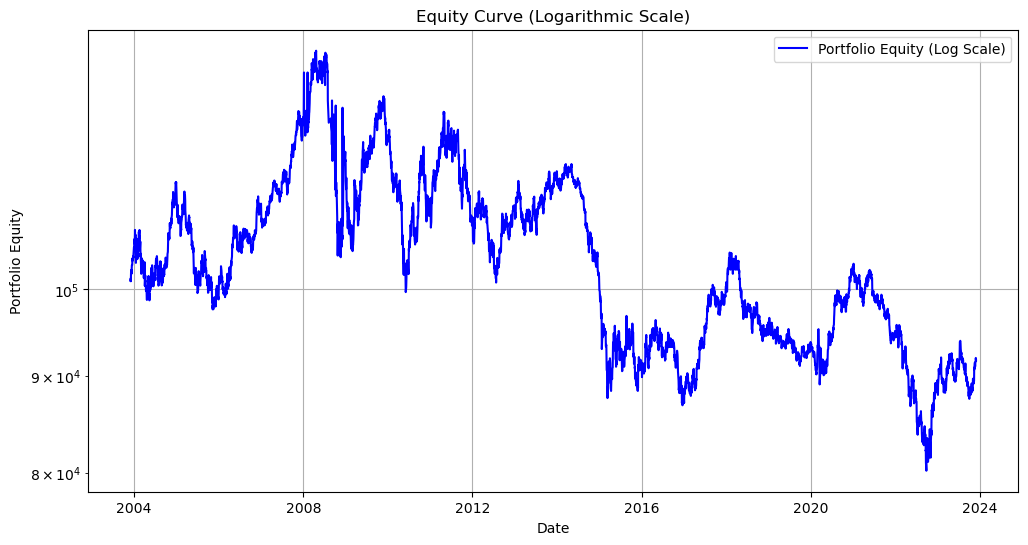

In [36]:
data = yf.download('EURUSD=X', start='1990-01-01', end='2023-12-01')
def simulate_eurusd_strategy(data, initial_capital):
    # Simulate overnight returns
    data['Overnight Return'] = (data['Close'].shift(-1) - data['Close']) / data['Close']

    # Calculate portfolio equity
    data['Portfolio Equity'] = initial_capital * (1 + data['Overnight Return'].fillna(0)).cumprod()
    return data

# Main execution
data = simulate_eurusd_strategy(data, initial_capital=100000)
metrics = calculate_performance(data)
print_performance_metrics(metrics)
plot_equity_curve(data)


Hyperparameters & Optimization

[*********************100%***********************]  1 of 1 completed


   Stop Loss  Take Profit      CAGR  Win Ratio  Profit Factor
0       0.01         0.01  0.113621   0.533419       1.173989
1       0.01         0.02  0.339254   0.533419       1.461508
2       0.01         0.03  0.407942   0.533419       1.540247
3       0.02         0.01 -0.085299   0.533419       0.904319
4       0.02         0.02  0.100031   0.533419       1.125794
5       0.02         0.03  0.156449   0.533419       1.186446
6       0.03         0.01 -0.141677   0.533419       0.842392
7       0.03         0.02  0.032230   0.533419       1.048700
8       0.03         0.03  0.085171   0.533419       1.105199


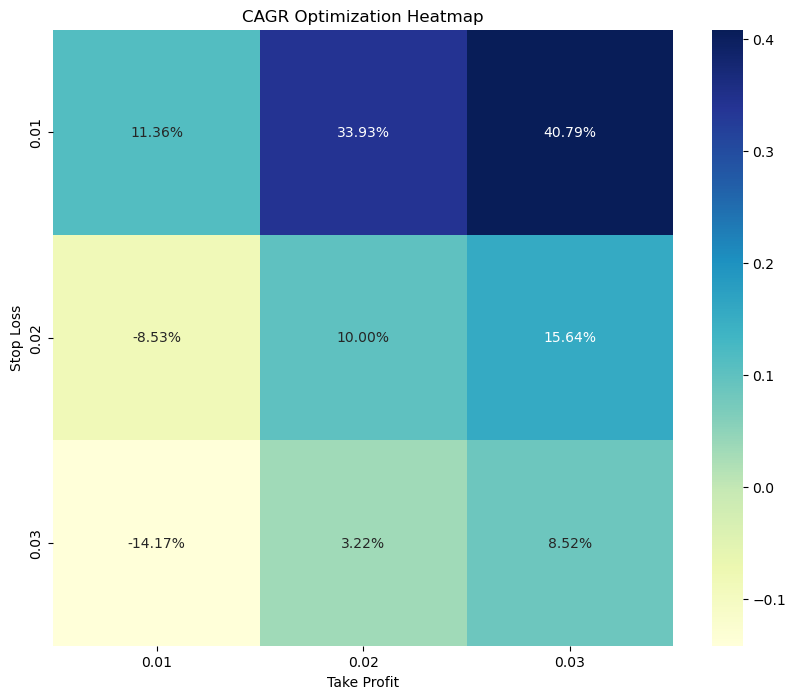

In [48]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns

# Function to download historical data
def download_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data['Return'] = data['Close'].pct_change()
    return data

# Function to simulate strategy with stop-loss and take-profit
def simulate_strategy_with_params(data, initial_capital, stop_loss, take_profit):
    data['Overnight Return'] = (data['Close'].shift(-1) - data['Close']) / data['Close']
    equity = initial_capital
    cumulative_returns = [initial_capital]
    winning_trades = 0
    losing_trades = 0
    total_return = 0
    win_return = 0
    loss_return = 0

    for i in range(len(data) - 1):
        entry_price = data['Close'].iloc[i]
        exit_price = data['Close'].iloc[i + 1]
        overnight_return = (exit_price - entry_price) / entry_price

        # Apply stop-loss and take-profit
        if overnight_return > take_profit:
            overnight_return = take_profit
            winning_trades += 1
            win_return += overnight_return
        elif overnight_return < -stop_loss:
            overnight_return = -stop_loss
            losing_trades += 1
            loss_return += overnight_return
        elif overnight_return > 0:
            winning_trades += 1
            win_return += overnight_return
        else:
            losing_trades += 1
            loss_return += overnight_return

        equity *= (1 + overnight_return)
        cumulative_returns.append(equity)
        total_return += overnight_return

    data['Portfolio Equity'] = cumulative_returns
    metrics = {
        'Total Trades': winning_trades + losing_trades,
        'Win Ratio': winning_trades / (winning_trades + losing_trades) if (winning_trades + losing_trades) > 0 else 0,
        'Profit Factor': abs(win_return / loss_return) if loss_return != 0 else float('inf')
    }
    return data, metrics

# Function to optimize hyperparameters
def optimize_hyperparameters(data, initial_capital, stop_loss_values, take_profit_values):
    results = []
    for stop_loss, take_profit in product(stop_loss_values, take_profit_values):
        simulated_data, metrics = simulate_strategy_with_params(data.copy(), initial_capital, stop_loss, take_profit)
        cagr = ((simulated_data['Portfolio Equity'].iloc[-1] / initial_capital) ** 
                (1 / (len(simulated_data) / 252)) - 1)
        results.append({
            'Stop Loss': stop_loss,
            'Take Profit': take_profit,
            'CAGR': cagr,
            'Win Ratio': metrics['Win Ratio'],
            'Profit Factor': metrics['Profit Factor']
        })
    return pd.DataFrame(results)

# Function to plot optimization results
def plot_optimization_results(results):
    # Filter out invalid or missing values
    results = results.replace([np.inf, -np.inf], np.nan).dropna()
    pivot_table = results.pivot(index='Stop Loss', columns='Take Profit', values='CAGR')

    # Handle empty pivot_table
    if pivot_table.empty:
        print("No valid results for optimization. Check your parameters or data.")
        return

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.title('CAGR Optimization Heatmap')
    plt.xlabel('Take Profit')
    plt.ylabel('Stop Loss')
    sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap="YlGnBu")
    plt.show()

# Main Execution
if __name__ == "__main__":
    symbol = "SPY"
    start_date = "1990-01-01"
    end_date = "2023-12-01"
    initial_capital = 100000

    # Hyperparameter ranges
    stop_loss_values = [0.01, 0.02, 0.03]
    take_profit_values = [0.01, 0.02, 0.03]

    # Download data
    data = download_data(symbol, start_date, end_date)

    # Optimize hyperparameters
    optimization_results = optimize_hyperparameters(data, initial_capital, stop_loss_values, take_profit_values)

    # Display results
    print(optimization_results)

    # Plot optimization results
    plot_optimization_results(optimization_results)


Robustness Test

/var/folders/66/nrg4tbxn0zq_dxpyc2gwmd6c0000gn/T/ipykernel_74350/292341192.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9992383534837939' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[data.index[i + 1], 'Cumulative Return'] = equity

1 Failed download:
['GBPUSD=X']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Running In-Sample Tests...
Fetching data for EURUSD=X from 2015-01-01 to 2020-12-31...
Fetching data for GBPUSD=X from 2015-01-01 to 2020-12-31...
No data available for GBPUSD=X.
Skipping GBPUSD=X due to missing or empty data.
Fetching data for USDJPY=X from 2015-01-01 to 2020-12-31...
Fetching data for AUDUSD=X from 2015-01-01 to 2020-12-31...


/var/folders/66/nrg4tbxn0zq_dxpyc2gwmd6c0000gn/T/ipykernel_74350/292341192.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0016462045015424' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[data.index[i + 1], 'Cumulative Return'] = equity
/var/folders/66/nrg4tbxn0zq_dxpyc2gwmd6c0000gn/T/ipykernel_74350/292341192.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0008177770178617' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[data.index[i + 1], 'Cumulative Return'] = equity
/var/folders/66/nrg4tbxn0zq_dxpyc2gwmd6c0000gn/T/ipykernel_74350/292341192.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.005782208063577' has dtype incomp


Running Out-of-Sample Tests...
Fetching data for EURUSD=X from 2021-01-01 to 2023-10-31...
Fetching data for GBPUSD=X from 2021-01-01 to 2023-10-31...
Fetching data for USDJPY=X from 2021-01-01 to 2023-10-31...
Fetching data for AUDUSD=X from 2021-01-01 to 2023-10-31...

Running Hourly Data Tests...
Fetching data for EURUSD=X from 2021-01-01 to 2023-10-31...
No data available for EURUSD=X.
Skipping EURUSD=X due to missing or empty data.
Fetching data for GBPUSD=X from 2021-01-01 to 2023-10-31...



1 Failed download:
['GBPUSD=X']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2021-01-01 -> 2023-10-31) (Yahoo error = "1h data not available for startTime=1609459200 and endTime=1698710400. The requested range must be within the last 730 days.")')

1 Failed download:
['USDJPY=X']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2021-01-01 -> 2023-10-31) (Yahoo error = "1h data not available for startTime=1609459200 and endTime=1698710400. The requested range must be within the last 730 days.")')

1 Failed download:
['AUDUSD=X']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2021-01-01 -> 2023-10-31) (Yahoo error = "1h data not available for startTime=1609459200 and endTime=1698710400. The requested range must be within the last 730 days.")')
/var/folders/66/nrg4tbxn0zq_dxpyc2gwmd6c0000gn/T/ipykernel_74350/292341192.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

No data available for GBPUSD=X.
Skipping GBPUSD=X due to missing or empty data.
Fetching data for USDJPY=X from 2021-01-01 to 2023-10-31...
No data available for USDJPY=X.
Skipping USDJPY=X due to missing or empty data.
Fetching data for AUDUSD=X from 2021-01-01 to 2023-10-31...
No data available for AUDUSD=X.
Skipping AUDUSD=X due to missing or empty data.

========== Performance Summary ==========
In-Sample - EURUSD=X: {'Total Trades': 1561, 'Average Return (%)': 0.013258709762439763, 'Win Rate (%)': 49.583600256245994, 'Final Portfolio Value': 1.2075531170497587}
In-Sample - GBPUSD=X: {'Total Trades': 0, 'Average Return (%)': 0, 'Win Rate (%)': 0, 'Final Portfolio Value': 1}
In-Sample - USDJPY=X: {'Total Trades': 1561, 'Average Return (%)': 0.005695135212383069, 'Win Rate (%)': 50.7367072389494, 'Final Portfolio Value': 1.0726167781545575}
In-Sample - AUDUSD=X: {'Total Trades': 1561, 'Average Return (%)': 0.017814935591890558, 'Win Rate (%)': 50.03203074951954, 'Final Portfolio Valu

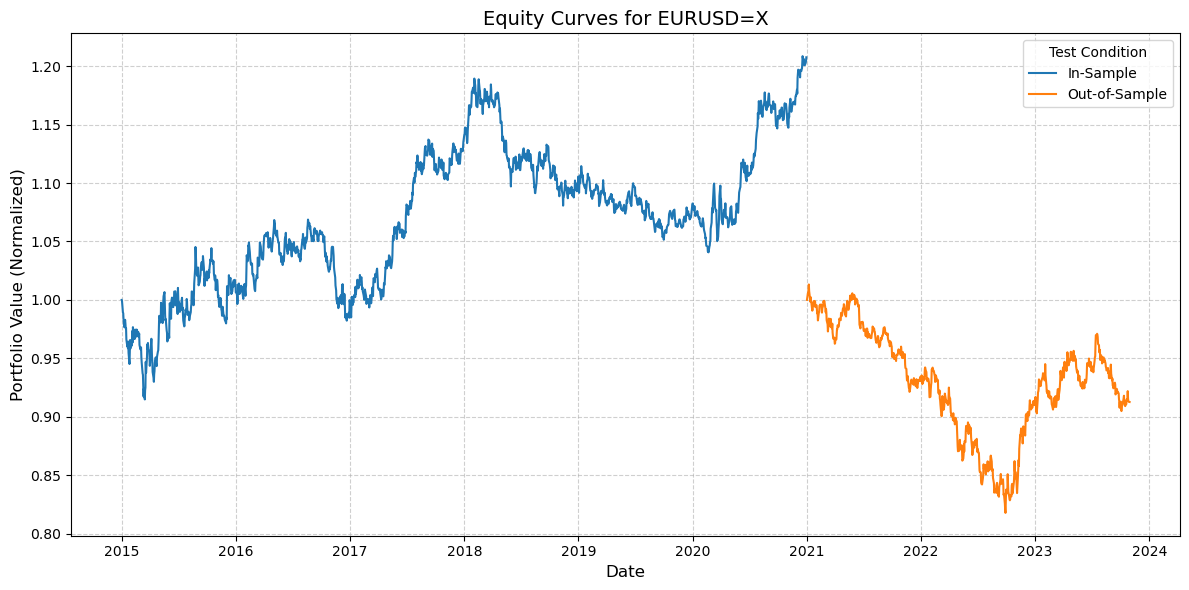

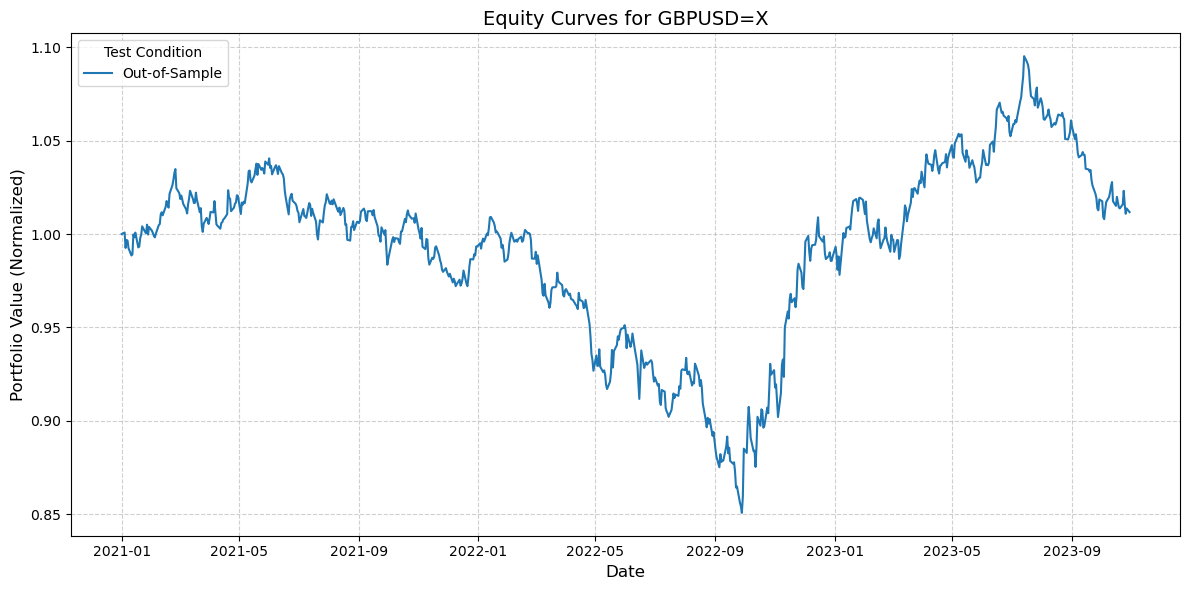

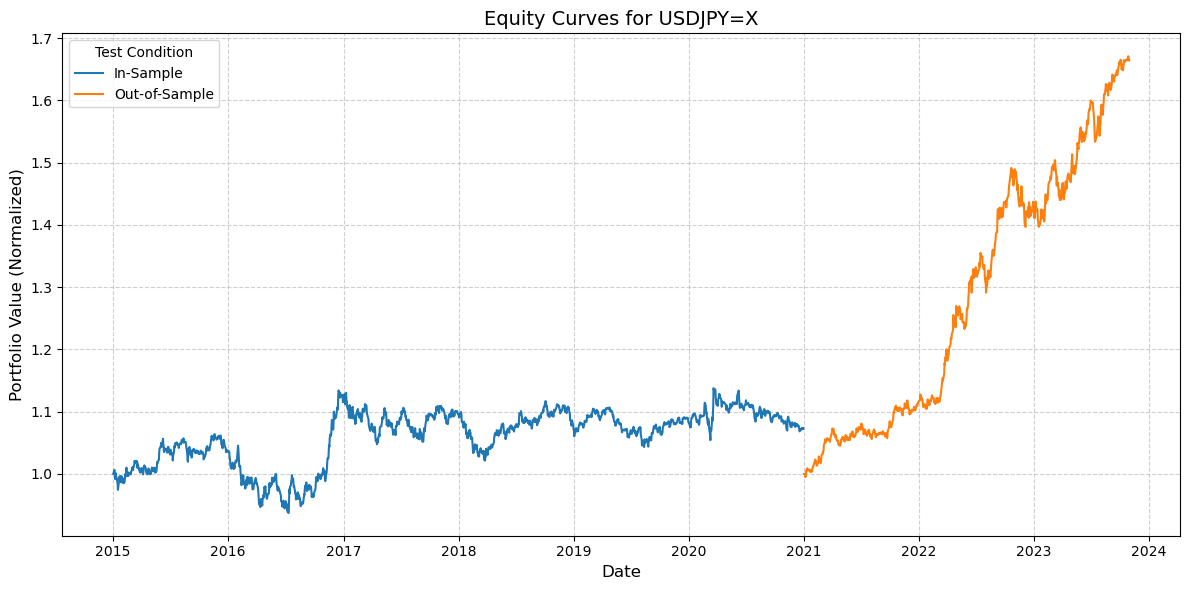

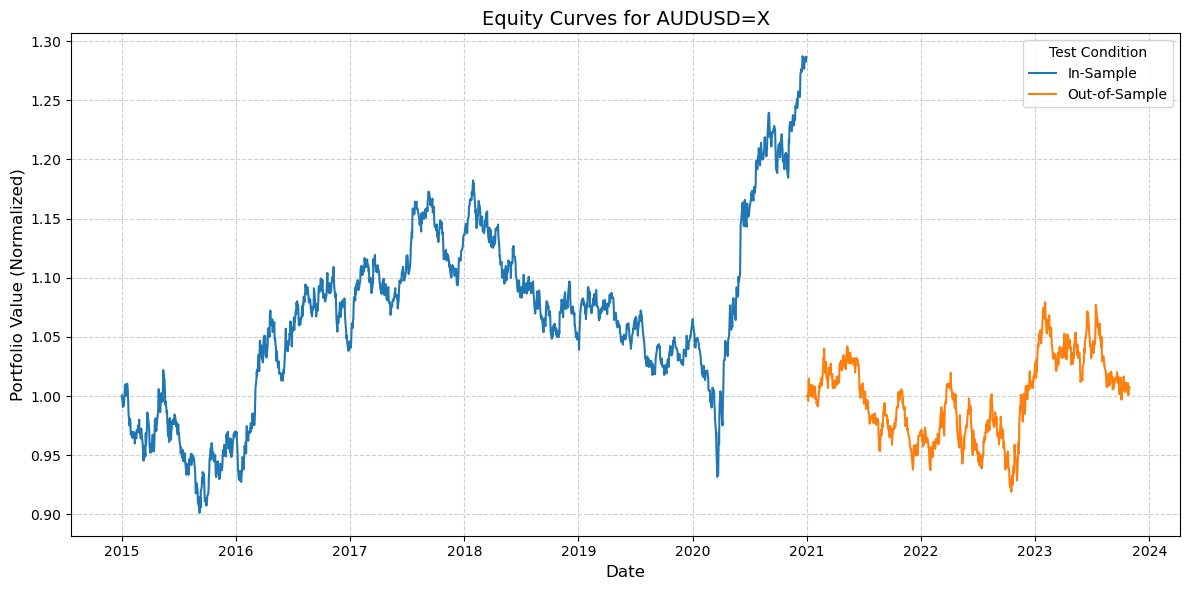

In [58]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Define date ranges for in-sample and out-of-sample testing
in_sample_start = '2015-01-01'
in_sample_end = '2020-12-31'
out_sample_start = '2021-01-01'
out_sample_end = '2023-10-31'

# List of currency pairs for robustness testing
symbols = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X']  # Major pairs

# Optimized parameters from heatmap
best_stop_loss = 0.01
best_take_profit = 0.03

# Fetch data
def fetch_data(symbol, start_date, end_date, interval='1d'):
    """Fetch historical data for a given symbol."""
    print(f"Fetching data for {symbol} from {start_date} to {end_date}...")
    try:
        data = yf.download(symbol, start=start_date, end=end_date, interval=interval, progress=False, timeout=20)
        if data.empty:
            print(f"No data available for {symbol}.")
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

# Simulate strategy with given parameters
def simulate_strategy(data, stop_loss, take_profit):
    """Simulate the strategy using stop-loss and take-profit."""
    if data.empty:
        return pd.DataFrame(), pd.DataFrame()

    data['Return'] = (data['Close'].shift(-1) - data['Close']) / data['Close']
    data['Cumulative Return'] = 1  # Initial portfolio value (normalized)
    trades = []

    equity = 1  # Start with 1 as normalized portfolio value
    for i in range(len(data) - 1):
        entry_price = data['Close'].iloc[i]
        exit_price = data['Close'].iloc[i + 1]
        trade_return = (exit_price - entry_price) / entry_price

        # Apply stop-loss and take-profit
        if trade_return > take_profit:
            trade_return = take_profit
        elif trade_return < -stop_loss:
            trade_return = -stop_loss

        # Update equity and log the trade
        equity *= (1 + trade_return)
        trades.append({
            'Entry Date': data.index[i],
            'Exit Date': data.index[i + 1],
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Return (%)': trade_return * 100,
        })

        # Store equity in the data
        data.at[data.index[i + 1], 'Cumulative Return'] = equity

    return pd.DataFrame(trades), data

# Perform robustness testing on multiple currency pairs
def robustness_test(symbols, stop_loss, take_profit, interval, sample_type):
    """Run robustness tests for multiple currency pairs."""
    all_trades = []
    equity_data = {}

    for symbol in symbols:
        # Fetch data for in-sample or out-of-sample testing
        start_date, end_date = (
            (in_sample_start, in_sample_end) if sample_type == "In-Sample" else (out_sample_start, out_sample_end)
        )
        data = fetch_data(symbol, start_date, end_date, interval)

        # Skip symbol if no data is available
        if data.empty:
            print(f"Skipping {symbol} due to missing or empty data.")
            continue

        # Simulate the strategy
        trades, data_with_equity = simulate_strategy(data, stop_loss, take_profit)

        # Append the trades to the list if any exist
        if not trades.empty:
            trades['Symbol'] = symbol
            trades['Sample'] = sample_type
            all_trades.append(trades)

        # Store equity data for plotting
        if not data_with_equity.empty:
            equity_data[symbol] = data_with_equity

    # Combine all trades into a single DataFrame
    return pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(), equity_data

# Calculate performance metrics
def calculate_performance(trades):
    """Calculate performance metrics from trades."""
    if trades.empty:
        return {
            "Total Trades": 0,
            "Average Return (%)": 0,
            "Win Rate (%)": 0,
            "Final Portfolio Value": 1,  # Start with normalized portfolio value
        }

    # Calculate portfolio value over time
    trades['Portfolio Value'] = (1 + trades['Return (%)'] / 100).cumprod()

    # Metrics
    total_trades = len(trades)
    avg_return = trades['Return (%)'].mean()
    win_rate = len(trades[trades['Return (%)'] > 0]) / total_trades * 100 if total_trades > 0 else 0
    final_portfolio = trades['Portfolio Value'].iloc[-1]

    return {
        "Total Trades": total_trades,
        "Average Return (%)": avg_return,
        "Win Rate (%)": win_rate,
        "Final Portfolio Value": final_portfolio,
    }

# Plot equity curves for different test conditions
def plot_equity_curves(data_dict, symbol):
    """
    Plot equity curves for different test conditions.
    
    Parameters:
        data_dict (dict): A dictionary where keys are test conditions (e.g., 'In-Sample')
                          and values are DataFrames with 'Cumulative Return'.
        symbol (str): The currency pair being tested.
    """
    plt.figure(figsize=(12, 6))
    for condition, data in data_dict.items():
        if not data.empty:
            plt.plot(data.index, data['Cumulative Return'], label=condition)

    # Add title, labels, and legend
    plt.title(f"Equity Curves for {symbol}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value (Normalized)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Test Condition", fontsize=10)
    plt.tight_layout()
    plt.show()

# Run tests for both in-sample and out-of-sample data
print("Running In-Sample Tests...")
trades_in_sample, equity_in_sample = robustness_test(
    symbols, best_stop_loss, best_take_profit, interval='1d', sample_type="In-Sample"
)

print("\nRunning Out-of-Sample Tests...")
trades_out_sample, equity_out_sample = robustness_test(
    symbols, best_stop_loss, best_take_profit, interval='1d', sample_type="Out-of-Sample"
)

print("\nRunning Hourly Data Tests...")
trades_hourly, equity_hourly = robustness_test(
    symbols, best_stop_loss, best_take_profit, interval='1h', sample_type="Hourly"
)

# Combine trades into a single DataFrame
all_trades = pd.concat([trades_in_sample, trades_out_sample, trades_hourly], ignore_index=True)

# Performance summaries
print("\n========== Performance Summary ==========")
for condition, trades in [("In-Sample", trades_in_sample), ("Out-of-Sample", trades_out_sample), ("Hourly", trades_hourly)]:
    for symbol in symbols:
        symbol_trades = trades[trades['Symbol'] == symbol] if not trades.empty else pd.DataFrame()
        metrics = calculate_performance(symbol_trades)
        print(f"{condition} - {symbol}: {metrics}")

# Plot equity curves for each symbol
for symbol in symbols:
    equity_data = {
        "In-Sample": equity_in_sample.get(symbol, pd.DataFrame()),
        "Out-of-Sample": equity_out_sample.get(symbol, pd.DataFrame()),
        "Hourly": equity_hourly.get(symbol, pd.DataFrame()),
    }
    plot_equity_curves(equity_data, symbol)
